### installations and imports

In [1]:
from datetime import datetime, timedelta
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline
import praw
import requests
import pandas as pd
import numpy as np
import time
import logging
import torch
import asyncio
import nest_asyncio
import aiohttp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy

# Apply nest_asyncio
nest_asyncio.apply()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

/Users/malik/Desktop/uni/6. Semester - SoSe 2024/Bachelorarbeit/bachelor project /.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### enable gpu

In [2]:
import tensorflow as tf

# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        print(f"Using GPU: {physical_devices[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available")

# Enable mixed precision training
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

Num GPUs Available:  1
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### fetch bitcoin data from 2017 to 2024

In [ ]:
def get_binance_data(symbol, interval, start_str, end_str=None):
    base_url = "https://api.binance.com"
    endpoint = "/api/v3/klines"
    
    start_ts = int(pd.to_datetime(start_str).timestamp() * 1000)
    end_ts = int(pd.to_datetime(end_str).timestamp() * 1000) if end_str else None
    
    data = []
    count = 0
    
    while True:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_ts,
            'limit': 1000
        }
        if end_ts:
            params['endTime'] = end_ts
        
        try:
            response = requests.get(base_url + endpoint, params=params)
            response.raise_for_status()
            
            results = response.json()
            
            if not results:
                break
            
            data.extend(results)
            
            start_ts = results[-1][0] + 1
            
            count += len(results)
            last_timestamp = pd.to_datetime(results[-1][0], unit='ms')
            print(f"Fetched {count} records, up to {last_timestamp}")
            
            if len(results) < 1000:
                break
            
        except requests.exceptions.HTTPError as err:
            if response.status_code == 429:
                print("Rate limit exceeded. Waiting before retrying...")
                time.sleep(60)  # Wait 1 minute before retrying
            else:
                raise err
    
    return data

def save_to_csv(data, filename):
    columns = [
        'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 
        'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 
        'taker_buy_quote_asset_volume', 'ignore'
    ]
    df = pd.DataFrame(data, columns=columns)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.to_csv(filename, index=False)

if __name__ == "__main__":
    symbol = "BTCUSDT"
    interval = "1m"
    start_date = "2010-01-01"
    end_date = "2024-05-27"
    
    print("Starting data fetch...")
    data = get_binance_data(symbol, interval, start_date, end_date)
    print("Data fetch complete. Saving to CSV...")
    save_to_csv(data, 'bitcoin_dataset.csv')
    print("Data saved to bitcoin_1min_data.csv")

### load transformer model

In [3]:
# Initialize sentiment analysis model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
max_length = 512  # Roberta's maximum sequence length


/Users/malik/Desktop/uni/6. Semester - SoSe 2024/Bachelorarbeit/bachelor project /.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-05-28 19:28:35.141971: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-28 19:28:35.141995: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-28 19:28:35.142001: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-28 19:28:35.142026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-28 19:28:35.142043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_facto

### configuration of reddit api

In [4]:
# Reddit API credentials
client_id = '-DikpAFUeeajlFFyWTBqUg'
client_secret = 'yZu1rPuBINVPuI7LuugQybGwtX1Cdg'
user_agent = 'bitcoin data'
username = '73malik'
password = 'Stapler437581'

# Create Reddit instance
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    username=username,
    password=password
)


### retrieve reddit posts

In [7]:
# Ensure you have the logging configuration set up to print messages to the console.
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Subreddit and Keyword definition
subreddit_name = 'all'
keywords = ['bitcoin price prediction', 'bitcoin market analysis', 'bitcoin trend', 'bitcoin forecast', 'bitcoin news']

# Fetch and analyze Reddit posts
def fetch_reddit_posts(subreddit_name, keywords, start_date, end_date, total_limit=1000, score_threshold=10):
    posts = []
    counter = 0
    requests_per_minute = 99  # Adjust based on the actual API limit

    current_date = start_date
    while current_date <= end_date:
        for keyword in keywords:
            logging.info(f"Fetching posts for keyword: {keyword} from date: {current_date.strftime('%Y-%m-%d')}")
            try:
                submissions = reddit.subreddit(subreddit_name).search(keyword, sort='new', limit=total_limit, time_filter='all')
                for submission in submissions:
                    created_date = datetime.fromtimestamp(submission.created_utc)
                    if created_date > end_date or counter >= total_limit:
                        break
                    if submission.score > score_threshold and created_date >= current_date:
                        created_date_str = created_date.strftime('%Y-%m-%d %H:%M:%S')
                        text = submission.title + " " + submission.selftext
                        sentiment = sentiment_pipeline(text)[0]['label']
                        post = {
                            'created': created_date_str,
                            'title': submission.title,
                            'score': submission.score,
                            'url': submission.url,
                            'content': submission.selftext,
                            'sentiment': sentiment
                        }
                        posts.append(post)
                        counter += 1
                        logging.info(f"Fetched post {counter}: {submission.title}")
                        print(post)  # Print the fetched post

                    if counter > 0 and counter % requests_per_minute == 0:
                        logging.info(f"Pausing to respect rate limit after {counter} requests.")
                        time.sleep(60)  # Sleep to respect rate limit

                logging.info(f"Finished fetching posts for keyword: {keyword} from date: {current_date.strftime('%Y-%m-%d')}")

            except Exception as e:
                logging.error(f"Error fetching posts for keyword {keyword} from date {current_date.strftime('%Y-%m-%d')}: {e}")

        current_date += timedelta(days=1)

    logging.info(f"Total posts fetched: {len(posts)}")
    return pd.DataFrame(posts)

# Define the start and end dates for fetching posts
start_date = datetime(2017, 1, 1)  # Adjusted start date to cover a longer period
end_date = datetime(2024, 5, 28)   # Example end date

# Fetch new posts
new_posts_df = fetch_reddit_posts(subreddit_name, keywords, start_date, end_date)

# Save the new posts DataFrame to CSV (replacing old data)
new_posts_df.to_csv('reddit_posts.csv', index=False)
logging.info(f"Total posts processed: {len(new_posts_df)}")
logging.info(f"Total unique posts: {len(new_posts_df)}")

# Print all fetched posts
print(new_posts_df)

2024-05-28 19:36:54,752 - INFO - Fetching posts for keyword: bitcoin price prediction from date: 2017-01-01
2024-05-28 19:36:56,237 - INFO - Finished fetching posts for keyword: bitcoin price prediction from date: 2017-01-01
2024-05-28 19:36:56,237 - INFO - Fetching posts for keyword: bitcoin market analysis from date: 2017-01-01
2024-05-28 19:36:58,136 - INFO - Finished fetching posts for keyword: bitcoin market analysis from date: 2017-01-01
2024-05-28 19:36:58,137 - INFO - Fetching posts for keyword: bitcoin trend from date: 2017-01-01
2024-05-28 19:36:59,793 - INFO - Finished fetching posts for keyword: bitcoin trend from date: 2017-01-01
2024-05-28 19:36:59,793 - INFO - Fetching posts for keyword: bitcoin forecast from date: 2017-01-01
2024-05-28 19:37:01,421 - INFO - Finished fetching posts for keyword: bitcoin forecast from date: 2017-01-01
2024-05-28 19:37:01,422 - INFO - Fetching posts for keyword: bitcoin news from date: 2017-01-01
2024-05-28 19:37:02,934 - INFO - Finished fe

KeyboardInterrupt: 

### prepare data

In [ ]:
# Example: Data preparation
def prepare_data(price_df, sentiment_df):
    # Convert timestamps to datetime
    sentiment_df['created'] = pd.to_datetime(sentiment_df['created'])
    price_df['timestamp'] = pd.to_datetime(price_df['open_time'])

    # Ensure both DataFrames are sorted by their respective keys
    price_df = price_df.sort_values('timestamp')
    sentiment_df = sentiment_df.sort_values('created')

    # Filter price_df to include only dates within the range of sentiment_df
    min_sentiment_date = sentiment_df['created'].min()
    max_sentiment_date = sentiment_df['created'].max()
    price_df = price_df[(price_df['timestamp'] >= min_sentiment_date) & (price_df['timestamp'] <= max_sentiment_date)]

    # Print the range of timestamps in both DataFrames
    print(f"Price data timestamp range: {price_df['timestamp'].min()} to {price_df['timestamp'].max()}")
    print(f"Sentiment data timestamp range: {sentiment_df['created'].min()} to {sentiment_df['created'].max()}")

    # Merge price and sentiment data on timestamp
    merged_df = pd.merge_asof(price_df, sentiment_df, left_on='timestamp', right_on='created', direction='backward')

    # Fill missing sentiment values with neutral sentiment
    merged_df['sentiment'] = merged_df['sentiment'].fillna('neutral')
    sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
    merged_df['sentiment_score'] = merged_df['sentiment'].map(sentiment_mapping)

    # Drop rows with NaN values
    merged_df = merged_df.dropna()

    # Check for NaN values after dropping
    print(f"NaN values after dropping: {merged_df.isna().sum()}")
    print(f"Merged DataFrame shape: {merged_df.shape}")

    # Prepare sequences
    sequence_length = 60  # e.g., last 60 minutes
    data = merged_df[['close', 'sentiment_score']].values
    print(f"Data length before sequence preparation: {len(data)}")
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length][0])  # Price prediction target

    x = np.array(x)
    y = np.array(y)
    
    # Check for NaN values in x and y before returning
    print(f"NaN values in x before returning: {np.isnan(x).sum()}")
    print(f"NaN values in y before returning: {np.isnan(y).sum()}")
    print(f"x shape: {x.shape}, y shape: {y.shape}")

    return x, y

# Load the price and sentiment data
price_df = pd.read_csv('bitcoin_dataset.csv')
sentiment_df = pd.read_csv('reddit_posts.csv')

# Prepare the data
x, y = prepare_data(price_df, sentiment_df)

# Check for NaN and infinite values
assert not np.any(np.isnan(x)), "NaN values found in x"
assert not np.any(np.isnan(y)), "NaN values found in y"
assert not np.any(np.isinf(x)), "Inf values found in x"
assert not np.any(np.isinf(y)), "Inf values found in y"

# Scale the data
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

x_scaled = scaler_x.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).reshape(y.shape)

print(f"Prepared data shapes: x={x_scaled.shape}, y={y_scaled.shape}")

Price data timestamp range: 2017-08-17 04:00:00 to 2024-05-27 00:00:00
Sentiment data timestamp range: 2024-04-09 09:48:21 to 2024-05-28 15:46:30
NaN values after dropping: open_time                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
ignore                          0
timestamp                       0
created                         0
title                           0
score                           0
url                             0
content                         0
sentiment                       0
sentiment_score                 0
dtype: int64
Merged DataFrame shape: (0, 20)
Data length before sequence preparation: 0
NaN values in x before returning: 0
NaN values in y before 

ValueError: cannot reshape array of size 0 into shape (0)

### build and train lstm model

In [ ]:
# Model building and training
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16))
    model.add(Dense(1, dtype='float32'))  # Specify output dtype for mixed precision
    
    optimizer = Adam(learning_rate=0.001)  # Reduced learning rate
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Build the LSTM model
input_shape = (x_scaled.shape[1], x_scaled.shape[2])
lstm_model = build_lstm_model(input_shape)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

# Train the model
lstm_model.fit(x_scaled, y_scaled, batch_size=128, epochs=50, validation_split=0.2, callbacks=[early_stopping, lr_schedule])

# Save the trained model
lstm_model.save('lstm_model.h5')

/Users/malik/Desktop/uni/6. Semester - SoSe 2024/Bachelorarbeit/bachelor project /.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
  764/22220 ━━━━━━━━━━━━━━━━━━━━ 9:56 28ms/step - loss: nan

KeyboardInterrupt: 

### predict future prices

111096/111096 ━━━━━━━━━━━━━━━━━━━━ 571s 5ms/step


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


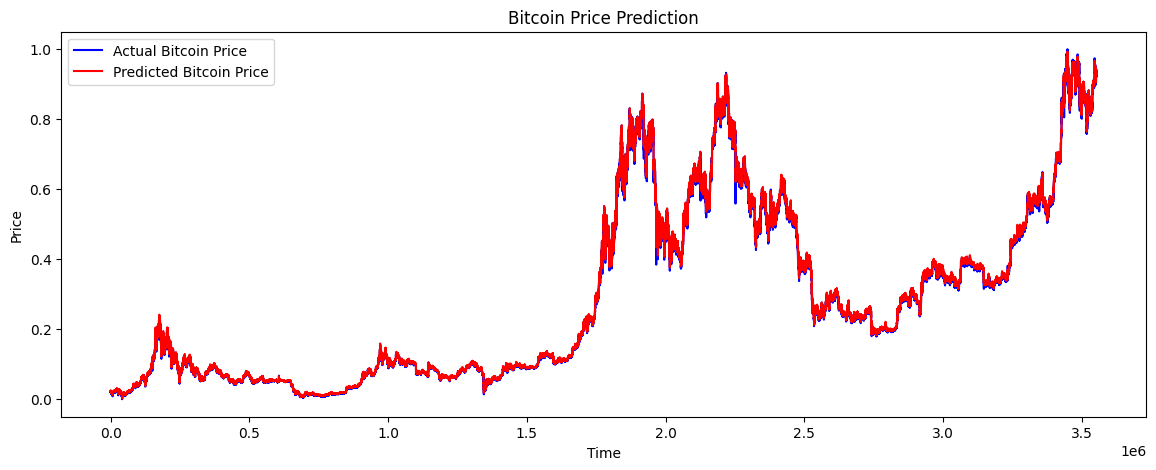

In [ ]:
# Load the trained model (if needed)
lstm_model = load_model('lstm_model.h5')

# Predict future prices
predictions = lstm_model.predict(x)

# Compare predictions with actual prices
plt.figure(figsize=(14,5))
plt.plot(y, color='blue', label='Actual Bitcoin Price')
plt.plot(predictions, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
def calculate_aoi(actual, predicted):
    # Ensure both arrays are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate the intersection area
    intersection_area = np.sum(np.minimum(actual, predicted))
    
    # Calculate the total area
    total_area_actual = np.sum(actual)
    total_area_predicted = np.sum(predicted)
    total_area = total_area_actual + total_area_predicted
    
    # Calculate AOI
    aoi = 2 * intersection_area / total_area
    return aoi

# Example usage with your actual and predicted data
# Assuming 'actual_prices' and 'predicted_prices' are the lists or arrays containing your data
actual_prices = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()  # Unscale the actual prices
predicted_prices = scaler_y.inverse_transform(predictions).flatten()  # Unscale the predicted prices

aoi_value = calculate_aoi(actual_prices, predicted_prices)
print(f"Average Overlap Index (AOI): {aoi_value:.4f}")